# 분석배경

00공장의 고객사에서 최근 들어 "Scale 불량 발생 증가"라는 이슈가 발생했다. 그 원인을 분석해 본 결과 압연공정에서 Scale 불량이 급증한 것을 확인할 수 있었다. 그래서 데이터를 수집하여 다양한 분석을 통해 불량 발생의 근본 원인을 찾고 결과를 해석하여 개선 기회를 도출한다.

# 0. 패키지

In [1]:
# 데이터 구성 패키지:Series, DataFrame
import pandas as pd
# 행렬 연산 패키지
import numpy as np
# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
# 데이터 분할:train/test
from sklearn.model_selection import train_test_split
# 분류 Decision Tree
from sklearn.tree import DecisionTreeClassifier as DTC
# 예측/회귀 Random Forest
from sklearn.ensemble import RandomForestClassifier as RFC
# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier as GBC
# 모델 성능 평가
from sklearn.metrics import confusion_matrix
# export_graphviz:나무 구조 생성 및 저장
from sklearn.tree import export_graphviz
# graphviz:나무 구조 시각화(.dot 확장자 파일 불러오기 등)
import graphviz

import warnings
warnings.filterwarnings('ignore')

matplotlib.rc('font',family='NanumGothic')

%matplotlib inline

# 1. 데이터 구성
## 1-1. 데이터 읽어들이기

In [2]:
# 데이터 읽어들이기
df_raw=pd.read_csv('/home/piai/Downloads/SCALE불량.csv',engine='python',encoding='cp949')
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


## 1-2. 결측치 확인

In [3]:
# 데이터 타입 확인
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLATE_NO           720 non-null    object 
 1   ROLLING_DATE       720 non-null    object 
 2   SCALE              720 non-null    object 
 3   SPEC               720 non-null    object 
 4   STEEL_KIND         720 non-null    object 
 5   PT_THK             720 non-null    float64
 6   PT_WDTH            720 non-null    int64  
 7   PT_LTH             720 non-null    int64  
 8   PT_WGT             720 non-null    int64  
 9   FUR_NO             720 non-null    object 
 10  FUR_NO_ROW         720 non-null    int64  
 11  FUR_HZ_TEMP        720 non-null    int64  
 12  FUR_HZ_TIME        720 non-null    int64  
 13  FUR_SZ_TEMP        720 non-null    int64  
 14  FUR_SZ_TIME        720 non-null    int64  
 15  FUR_TIME           720 non-null    int64  
 16  FUR_EXTEMP         720 non

* 데이터의 각 변수의 데이터 타입과 결측치를 확인한다. 결측치는 없는 것으로 확인되었다.

In [4]:
# Plate 번호, 작업시간, 제품규격 변수 제거
df_raw.drop(['PLATE_NO','ROLLING_DATE','SPEC'], axis = 1, inplace = True)

df_raw.head()

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,양품,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934,적용,8,2조
1,양품,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937,적용,8,2조
2,양품,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889,적용,8,3조
3,양품,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,적용,8,3조
4,양품,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,적용,8,1조


* PLATE_NO(Plate No)와 ROLLING_DATE(작업시각)은 중요하지 않은 변수라고 판단되어 제거한다.

## 1-3. 이상치 확인

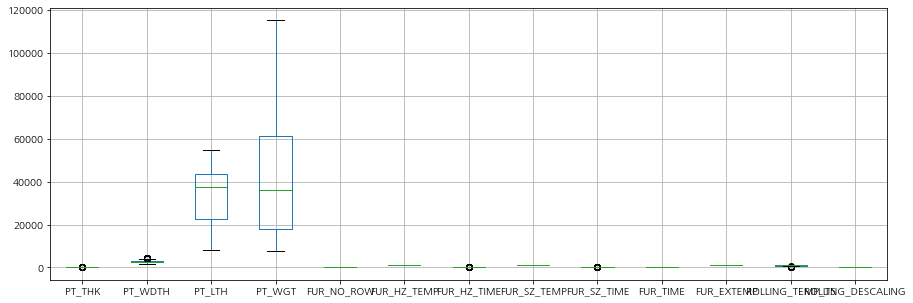

In [5]:
# 전체 데이터에서 상자 수염도를 이용한 이상치 확인
df_raw.boxplot(figsize=(15,5))

* 눈에 띄는 이상치가 보이지 않는다.

# 2. 변수 영향력 확인
## 2-1. 연속형 설명변수 히스토그램
### Scale의 양품/불량 기준

In [6]:
# 연속형 변수 추출
df_raw_numeric = df_raw.select_dtypes(exclude = 'object')
df_raw_numeric.shape

(720, 13)

In [7]:
df_raw_numeric_x = df_raw_numeric
df_raw_numeric_y = df_raw['SCALE']

df_raw_numeric_x

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
0,32.25,3707,15109,14180,1,1144,116,1133,59,282,1133,934,8
1,32.25,3707,15109,14180,2,1144,122,1135,53,283,1135,937,8
2,33.27,3619,19181,18130,1,1129,116,1121,55,282,1121,889,8
3,33.27,3619,19181,18130,2,1152,125,1127,68,316,1127,885,8
4,38.33,3098,13334,12430,1,1140,134,1128,48,314,1128,873,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,20.14,3580,38639,21870,1,1172,72,1164,62,245,1164,1005,8
716,15.08,3212,48233,18340,1,1150,61,1169,61,238,1169,947,10
717,16.60,3441,43688,19590,2,1169,65,1163,77,247,1163,948,10
718,15.59,3363,48740,80240,2,1179,86,1163,45,243,1163,940,10


In [8]:
df_raw_numeric_y

0      양품
1      양품
2      양품
3      양품
4      양품
       ..
715    불량
716    양품
717    양품
718    양품
719    양품
Name: SCALE, Length: 720, dtype: object

In [9]:
def fun_plot_hist(data,var):
    plt.hist(data[data['SCALE']=='양품'][var],label='양품',alpha=0.5)
    plt.hist(data[data['SCALE']=='불량'][var],label='불량',alpha=0.5)
    plt.legend()

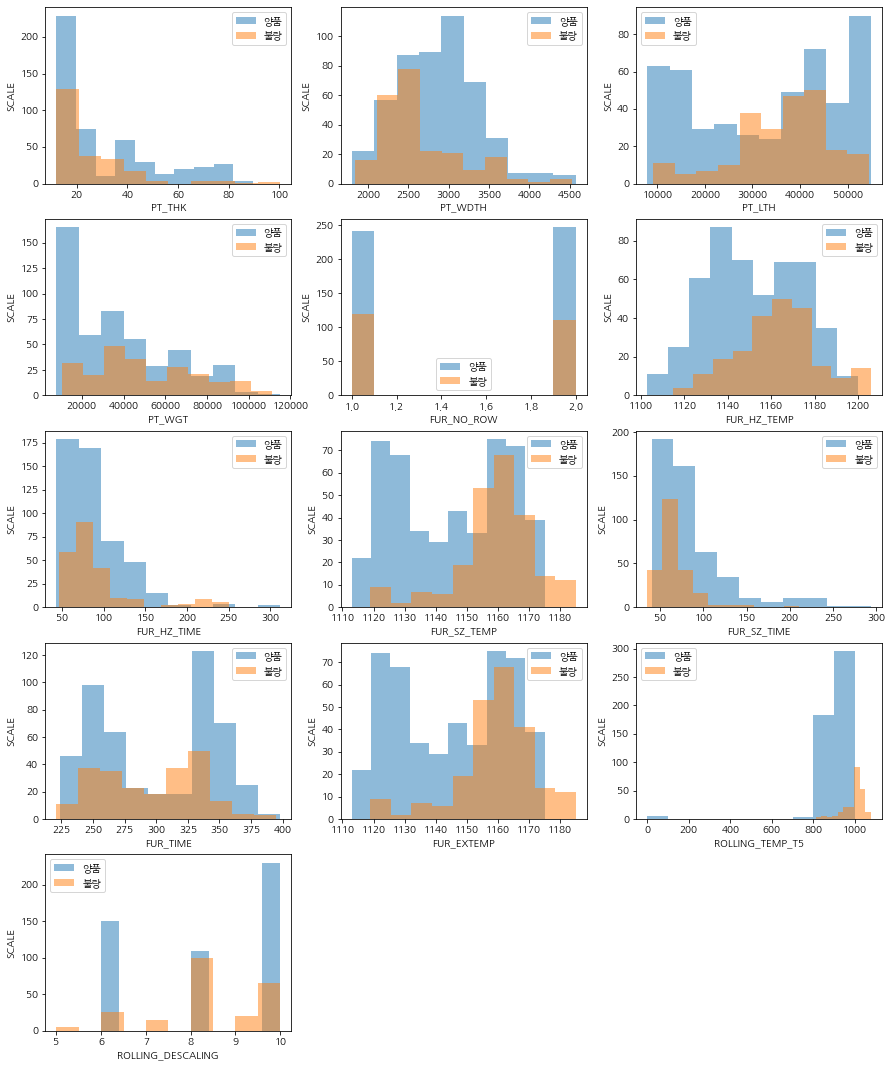

In [10]:
i = 0
fig = plt.figure(figsize = (15, 50))
columns = df_raw_numeric_x.columns
for col in columns:
    plt.subplot(df_raw_numeric_x.shape[1], 3, i+1)
    i += 1
    plt.hist(df_raw[df_raw["SCALE"] == '양품'][col], label = "양품", alpha = 0.5)
    plt.hist(df_raw[df_raw["SCALE"] == '불량'][col], label = "불량", alpha = 0.5)
    plt.xlabel(col)
    plt.ylabel("SCALE")
    plt.legend()
plt.show()

* PT_THK:Plate의 두께가 얇을수록 Scale의 불량률이 높아진다.
* PT_WDTH:Plate의 폭이 작을수록 Scale의 불량률이 높아진다.
* PT_LTH:Plate의 길이가 30000~40000일 때 Scale의 불량률이 높아진다.
* PT_WGT:Plate의 중량이 클수록 Scale의 불량률이 커진다.
* FUR_NO:가열로는 2호기가 가장 Scale 불량률이 낮고, 3호기가 가장 높다.
* FUR_NO_ROW:가열로의 작업순번의 1번이 2번보다 Scale 불량률이 높다.
* FUR_HZ_TEMP:가열로의 가열대 온도가 높을수록 Scale의 불량률이 높아진다.
* FUR_HZ_TIME:가열로의 가열대 시간이 200~250 일 때 Scale의 불량률이 높다.
* FUR_SZ_TEMP:가열로의 균열대 온도가 100도 이하일 때, Scale의 불량이 많이 생긴다.
* FUR_SZ_TIME:가열로의 균열대 시간이 275~325일 때 Scale의 불량률이 가장 높게 나타난다. 그래서 가열로의 시간과 Scale의 불량률과는 큰 관계가 없다고 판단이 된다.
* FUR_EXTEMP:추출온도가 높을수록 Scale의 불량률이 높아진다.
* ROLLING_TEMP_T5:압연온도가 높을수록 불량률이 높게 나온다.
* ROLLING DESCALING:압연 중 Descaling의 횟수와 Scale의 불량률과는 관계가 없다고 판단된다.

* ROLLING_TEMP_T5에서 압연온도가 200 이하일 때 이상치가 발견되었으니 이상치를 제거한다.

In [11]:
# ROLLING_TEMP_T5 이상치 확인
df_raw[df_raw["ROLLING_TEMP_T5"]<200]

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
41,양품,T8,55.51,3765,11398,37400,3호기,2,1132,95,1128,80,341,1128,0,적용,6,1조
184,양품,C0,16.09,2221,43596,61150,3호기,1,1169,64,1164,61,308,1164,0,적용,10,3조
185,양품,C0,16.09,2221,43596,61150,3호기,2,1163,57,1166,67,303,1166,0,적용,10,4조
494,양품,T5,80.82,2085,12919,17090,2호기,1,1133,89,1122,59,378,1122,0,적용,6,2조
495,양품,T5,80.82,2085,13176,17430,1호기,2,1130,92,1124,61,362,1124,0,적용,6,3조
496,양품,T0,40.35,2497,23592,37320,3호기,1,1119,109,1117,76,383,1117,0,적용,6,3조


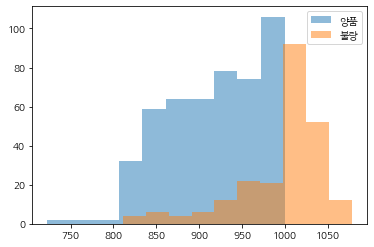

In [12]:
df_raw = df_raw.drop([41,184,185,494,495,496])
df_raw.reset_index(drop=True, inplace=True)

fun_plot_hist(df_raw,'ROLLING_TEMP_T5')

* 이상치가 정상적으로 제거되었다.

## 2-2. 범주형 설명변수 crosstab

In [13]:
df_raw_char = df_raw.select_dtypes(include = 'object')
df_raw_char.head()

,SCALE,STEEL_KIND,FUR_NO,HSB,WORK_GR
0,양품,T1,1호기,적용,2조
1,양품,T1,1호기,적용,2조
2,양품,T8,2호기,적용,3조
3,양품,T8,2호기,적용,3조
4,양품,T8,3호기,적용,1조


In [14]:
def fun_print_crosstab(data,var):
    print(pd.crosstab(index=data['SCALE'],columns=data[var]))
    print()
    print(pd.crosstab(index=data['SCALE'],columns=data[var],normalize='columns'))

#### (1) STEEL_KIND(강종)

In [15]:
fun_print_crosstab(df_raw,'STEEL_KIND')

STEEL_KIND   C0  C1  C3  T0  T1  T3  T5  T7  T8
SCALE                                          
불량          212   1   1   2   2   0   2   6   5
양품          289   0   6  13  16   2  39  29  89

STEEL_KIND        C0   C1        C3        T0        T1   T3       T5  \
SCALE                                                                   
불량          0.423154  1.0  0.142857  0.133333  0.111111  0.0  0.04878   
양품          0.576846  0.0  0.857143  0.866667  0.888889  1.0  0.95122   

STEEL_KIND        T7        T8  
SCALE                           
불량          0.171429  0.053191  
양품          0.828571  0.946809  


* 강종별로 불량률의 차이가 높은 것으로 보아 변수의 영향력이 클 것으로 예상된다. 하지만 강종별 데이터 수의 편차가 크므로 구체적으로 확인해볼 필요가 있다. 하지만 C0 이외의 강종의 데이터가 부족하니 변수를 제거한다.

In [16]:
# STEEL_KIND(강종) 변수 제거
df_raw.drop(['STEEL_KIND'], axis = 1, inplace = True)

#### (2) FUR_NO(가열로 호기)

In [17]:
fun_print_crosstab(df_raw,'FUR_NO')

FUR_NO  1호기  2호기  3호기
SCALE                
불량       73   70   88
양품      166  166  151

FUR_NO       1호기      2호기       3호기
SCALE                              
불량      0.305439  0.29661  0.368201
양품      0.694561  0.70339  0.631799


* 가열로 호기별로 불량률의 차이가 크지 않으므로 변수의 영향력이 작다고 분석할 수 있다.

#### (3) HSB

In [18]:
fun_print_crosstab(df_raw,'HSB')

HSB    미적용   적용
SCALE          
불량      33  198
양품       0  483

HSB    미적용        적용
SCALE               
불량     1.0  0.290749
양품     0.0  0.709251


* HSB를 미적용했을 때 불량률은 100%이다. HSB의 영향력이 클 것으로 예상된다.

#### (4) WORK_GR(작업조)

In [19]:
fun_print_crosstab(df_raw,'WORK_GR')

WORK_GR   1조   2조   3조   4조
SCALE                      
불량        67   45   54   65
양품       121  119  115  128

WORK_GR        1조       2조        3조        4조
SCALE                                         
불량       0.356383  0.27439  0.319527  0.336788
양품       0.643617  0.72561  0.680473  0.663212


* 작업조별 불량률의 차이는 작으므로 변수의 영향력이 작다고 분석할 수 있다.

## 3. 데이터 구성
### 3-1. 목표변수의 형 변환

In [20]:
df_raw['SCALE']=np.where(df_raw['SCALE']=='양품',0,1)
df_raw['SCALE'].head()

0    0
1    0
2    0
3    0
4    0
Name: SCALE, dtype: int64

In [21]:
df_raw.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,0,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934,적용,8,2조
1,0,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937,적용,8,2조
2,0,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889,적용,8,3조
3,0,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,적용,8,3조
4,0,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,적용,8,1조


## 3-2. 데이터 분할

In [22]:
df_train, df_test = train_test_split(df_raw,test_size = 0.3, random_state = 1234)
print('shape of train data:',df_train.shape)
print('shape of test data:',df_test.shape)

shape of train data: (499, 17)
shape of test data: (215, 17)


## 3-3. 변수 역할 지정

In [23]:
# 목표변수와 설명변수의 역할을 지정
df_raw_y=df_raw['SCALE']
df_raw_x=df_raw.drop('SCALE',axis=1,inplace=False)

## 3-4. 더미변수 생성

In [24]:
df_dummy=pd.get_dummies(df_raw_x)
print('Shape of dummy:',df_dummy.shape)
df_dummy.head()

Shape of dummy: (714, 22)


,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,...,ROLLING_DESCALING,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,32.25,3707,15109,14180,1,1144,116,1133,59,282,...,8,1,0,0,0,1,0,1,0,0
1,32.25,3707,15109,14180,2,1144,122,1135,53,283,...,8,1,0,0,0,1,0,1,0,0
2,33.27,3619,19181,18130,1,1129,116,1121,55,282,...,8,0,1,0,0,1,0,0,1,0
3,33.27,3619,19181,18130,2,1152,125,1127,68,316,...,8,0,1,0,0,1,0,0,1,0
4,38.33,3098,13334,12430,1,1140,134,1128,48,314,...,8,0,0,1,0,1,1,0,0,0


## 3-5. 데이터 분할

In [25]:
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_dummy,\
                                                              df_raw_y,test_size = 0.3,random_state = 1234)
print(f'train data X size :{df_train_x.shape}')
print(f'train data Y size :{df_train_y.shape}')
print(f'test data X size :{df_test_x.shape}')
print(f'test data Y size :{df_test_y.shape}')

train data X size :(499, 22)
train data Y size :(499,)
test data X size :(215, 22)
test data Y size :(215,)


# 4. Vital Few 탐색
## 4-1. Decision Tree
### (1) 예측 및 평가

In [26]:
tree_final=DTC(random_state=1234)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeClassifier(random_state=1234)

In [27]:
y_pred=tree_final.predict(df_test_x)
print('Accuracy:{0:.3f}\n'.format(tree_final.score(df_test_x,df_test_y)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_test_y,y_pred)))

Accuracy:0.949

Confusion Matrix:
[[141   3]
 [  8  63]]


* DT 모델의 정확도는 94.9%이다.

### (2) 변수 중요도

In [28]:
# 설명변수의 중요도 확인 및 저장
df_importance=pd.DataFrame()
df_importance['Feature']=df_train_x.columns
df_importance['Importance']=tree_final.feature_importances_

df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance.round(3)

,Feature,Importance
11,ROLLING_TEMP_T5,0.575
16,HSB_미적용,0.174
10,FUR_EXTEMP,0.112
12,ROLLING_DESCALING,0.062
9,FUR_TIME,0.015
8,FUR_SZ_TIME,0.014
0,PT_THK,0.012
5,FUR_HZ_TEMP,0.009
21,WORK_GR_4조,0.009
1,PT_WDTH,0.006


Text(0, 0.5, '설명변수')

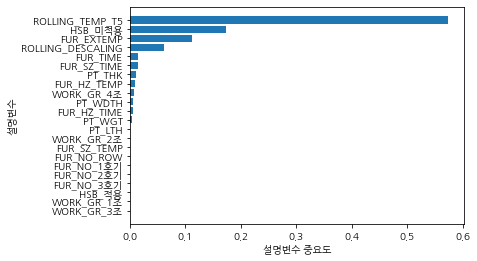

In [29]:
# 설명변수 중요도 그래프
df_importance.sort_values('Importance',ascending=True,inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates,width=df_importance['Importance'])
plt.yticks(coordinates,df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

* 다음과 같은 순서로 변수의 중요도를 파악할 수 있다.

## 4-2. Random Forest
### (1) 예측 및 평가

In [30]:
rf_final=RFC(random_state=1234)
rf_final.fit(df_train_x,df_train_y)

y_pred=rf_final.predict(df_test_x)
print('Accuracy:{0:.3f}\n'.format(tree_final.score(df_test_x,df_test_y)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_test_y,y_pred)))

Accuracy:0.949

Confusion Matrix:
[[144   0]
 [ 10  61]]


### (2) 변수 중요도

In [31]:
# 설명변수의 중요도 확인 및 저장
df_importance=pd.DataFrame()
df_importance['Feature']=df_train_x.columns
df_importance['Importance']=rf_final.feature_importances_

df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance

,Feature,Importance
11,ROLLING_TEMP_T5,0.311514
10,FUR_EXTEMP,0.089275
7,FUR_SZ_TEMP,0.084781
12,ROLLING_DESCALING,0.072379
17,HSB_적용,0.062452
16,HSB_미적용,0.060713
1,PT_WDTH,0.054175
0,PT_THK,0.048592
5,FUR_HZ_TEMP,0.042864
2,PT_LTH,0.040597


Text(0, 0.5, '설명변수')

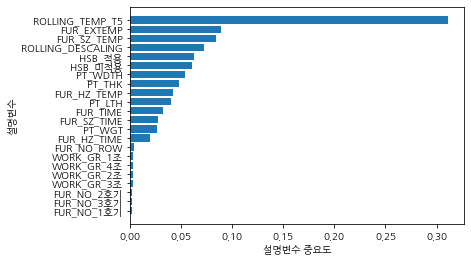

In [32]:
# 설명변수 중요도 그래프
df_importance.sort_values('Importance',ascending=True,inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates,width=df_importance['Importance'])
plt.yticks(coordinates,df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

* 다음과 같은 순서로 변수의 중요도를 파악할 수 있다.

## 4-3. Gradient Boosting
### (1) 예측 및 평가

In [33]:
gb_final=GBC(random_state=1234)
gb_final.fit(df_train_x,df_train_y)
y_pred=gb_final.predict(df_test_x)

print('Accuracy:{0:.3f}\n'.format(gb_final.score(df_test_x,df_test_y)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_test_y,y_pred)))

Accuracy:0.972

Confusion Matrix:
[[144   0]
 [  6  65]]


### (2) 설명변수 중요도

In [34]:
# 설명변수의 중요도 확인 및 저장
df_importance=pd.DataFrame()
df_importance['Feature']=df_train_x.columns
df_importance['Importance']=gb_final.feature_importances_

df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance

,Feature,Importance
11,ROLLING_TEMP_T5,5.811852e-01
17,HSB_적용,1.047665e-01
7,FUR_SZ_TEMP,9.391135e-02
16,HSB_미적용,7.393469e-02
12,ROLLING_DESCALING,5.260328e-02
0,PT_THK,4.144469e-02
10,FUR_EXTEMP,2.575285e-02
1,PT_WDTH,8.265664e-03
5,FUR_HZ_TEMP,7.951907e-03
8,FUR_SZ_TIME,3.894695e-03


Text(0, 0.5, '설명변수')

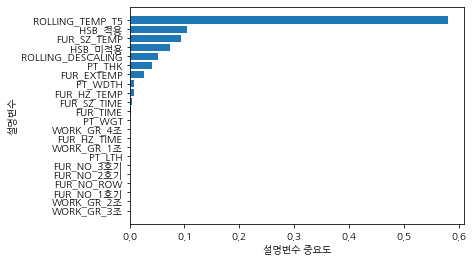

In [35]:
# 설명변수 중요도 그래프
df_importance.sort_values('Importance',ascending=True,inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates,width=df_importance['Importance'])
plt.yticks(coordinates,df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

* 연속형 설명변수의 Histogram, 범주형 설명변수의 Crosstab, DT의 설명변수 중요도, RF의 설명변수 중요도, GB의 설명변수 중요도에 따라 각 설명변수에 점수를 매겼다. 그결과 Scale 불량 발생에 영향을 주는 인자의 TOP 5는 ROLLING_TEMP_T5, HSB, FUR_EXTEMP, FUR_SZ_TEMP, ROLLING_DESCALING 으로 나타났다.
* 이제 TOP 5 변수를 사용하여 모델을 생성하고 Hyper Parameter를 찾아가며 모델을 개선시킨다.

# 5. 의사결정나무
## 5-1. 기본 옵션으로 모델 생성

In [36]:
df_train_x=df_train_x[['ROLLING_TEMP_T5', 'HSB_미적용','HSB_적용', 'FUR_EXTEMP', 'FUR_SZ_TEMP', 'ROLLING_DESCALING']]
df_test_x=df_test_x[['ROLLING_TEMP_T5', 'HSB_미적용','HSB_적용', 'FUR_EXTEMP', 'FUR_SZ_TEMP', 'ROLLING_DESCALING']]

In [37]:
df_train_x.head()

,ROLLING_TEMP_T5,HSB_미적용,HSB_적용,FUR_EXTEMP,FUR_SZ_TEMP,ROLLING_DESCALING
206,1032,0,1,1158,1158,8
59,851,0,1,1134,1134,5
13,926,0,1,1120,1120,8
151,1030,0,1,1162,1162,8
485,878,0,1,1119,1119,6


In [38]:
tree_uncustomized=DTC(random_state=1234)
tree_uncustomized.fit(df_train_x,df_train_y)
# Train 데이터 정확도
print('Accuracy on training set:{:.3f}'.format(tree_uncustomized.score(df_train_x,df_train_y)))
# Test 데이터 정확도
print('Accuracy on test set:{:.3f}'.format(tree_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set:1.000
Accuracy on test set:0.977


* 모델은 training set에 100%, test set에 97.7%의 정확도를 갖는다.
* 모델은 모든 데이터에 과대적합의 경향을 보이므로 지금부터 Hyper Parameter를 찾아간다.

## 5-2. 현재 생성된 모델의 옵션 확인

In [39]:
tree_uncustomized

DecisionTreeClassifier(random_state=1234)

## 5-3. 모델 Parameter 조정
### (1) max_depth(최대 깊이)

In [40]:
# 최대 깊이 변경에 따른 모델 성능
# train 및 test 정확도 결과 저장
train_accuracy=[]
test_accuracy=[]
# max_depth:최대 깊이 변경
para_depth=[depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=DTC(random_state=1234,max_depth=v_max_depth)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_depth=pd.DataFrame()
df_accuracy_depth['Depth']=para_depth
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy']=test_accuracy

# 모델 정확도 확인
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.890,0.888
1,2,0.938,0.921
2,3,0.966,0.953
3,4,0.976,0.953
4,5,0.976,0.953
5,6,0.982,0.967
6,7,0.986,0.953
7,8,0.988,0.944
8,9,1.000,0.977
9,10,1.000,0.977


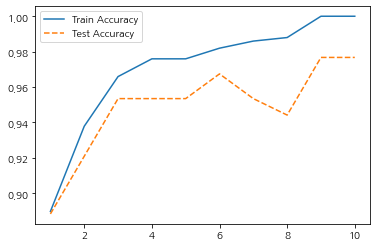

In [41]:
# 모델 정확도 그래프 확인
plt.plot(para_depth,train_accuracy,linestyle='-',label='Train Accuracy')
plt.plot(para_depth,test_accuracy,linestyle='--',label='Test Accuracy')
plt.legend()

* 최대 깊이 증가에 따라 모델의 정확도는 증가한다.
* max_depth는 6으로 지정한다.

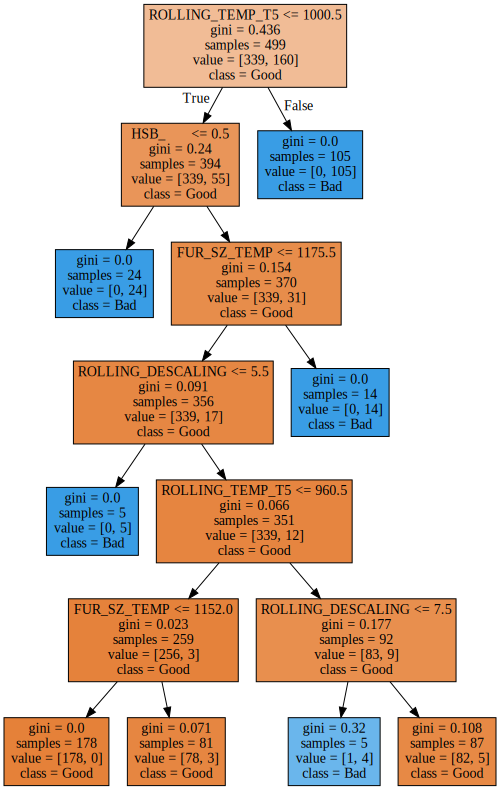

In [42]:
# 변수명 저장
v_feature_name=df_train_x.columns

# 최대 깊이=4 모델
tree_low=DTC(random_state=1234,max_depth=6)
tree_low.fit(df_train_x,df_train_y)

# 트리 모델을 tree_depth.dot 파일로 저장
export_graphviz(tree_low,out_file='tree_depth.dot',class_names=['Good','Bad'],\
                feature_names=v_feature_name,impurity=True,filled=True)

# graphviz를 이용해 트리 모델 시각화
with open('tree_depth.dot') as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

### (2) min_samples_split(분리 노드의 최소 자료 수)

In [43]:
# train 및 test 정확도 결과 저장
train_accuracy=[]
test_accuracy=[]
# min_samples_split:분리 노드의 최소 자료 수
para_split=[n_split*10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    tree=DTC(random_state=1234,max_depth=6,\
                               min_samples_split=v_min_samples_split)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_split=pd.DataFrame()
df_accuracy_split['MinSamplesSplit']=para_split
df_accuracy_split['TrainAccuracy']=train_accuracy
df_accuracy_split['TestAccuracy']=test_accuracy

# 모델 정확도 확인
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.982,0.967
1,20,0.982,0.967
2,30,0.982,0.967
3,40,0.982,0.967
4,50,0.982,0.967
5,60,0.982,0.967
6,70,0.982,0.967
7,80,0.982,0.967
8,90,0.982,0.967
9,100,0.976,0.953


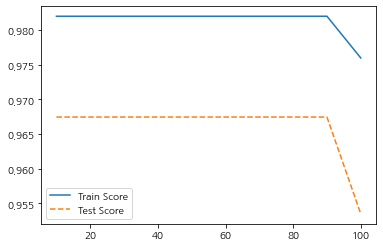

In [44]:
# 모델 정확도 그래프 확인
plt.plot(para_split,train_accuracy,linestyle='-',label='Train Score')
plt.plot(para_split,test_accuracy,linestyle='--',label='Test Score')
plt.legend()

* 분리 노드의 최소 자료 수는 20을 선택한다.

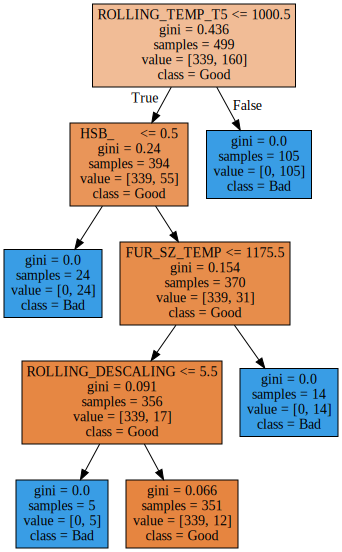

In [45]:
# 분리 노드의 최소 자료 수=20 모델
tree_low=DTC(max_depth=4,min_samples_split=20,random_state=1234)
tree_low.fit(df_train_x,df_train_y)

# 트리 모델을 tree_low.dot 파일로 저장
export_graphviz(tree_low,out_file='tree_split.dot',class_names=['Good','Bad'],\
               feature_names=v_feature_name,impurity=True,filled=True)

# graphviz를 이용해 트리 모델 시각화
with open('tree_split.dot') as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

### (3) min_samples_leaf(잎사귀 노드의 최소 자료 수)

In [46]:
# train 및 test 정확도 결과 저장
train_accuracy=[]
test_accuracy=[]

# min_samples_leaf:잎사귀 노드의 최소 자료 수
para_leaf=[n_leaf*2 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    tree=DTC(random_state=1234,max_depth=4,min_samples_split=20,\
             min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_leaf=pd.DataFrame()
df_accuracy_leaf['MinSamplesLeaf']=para_leaf
df_accuracy_leaf['TrainAccuracy']=train_accuracy
df_accuracy_leaf['TestAccuracy']=test_accuracy

# 모델 정확도 확인
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,2,0.976,0.953
1,4,0.976,0.953
2,6,0.966,0.953
3,8,0.966,0.953
4,10,0.966,0.953
5,12,0.966,0.953
6,14,0.966,0.953
7,16,0.962,0.949
8,18,0.952,0.944
9,20,0.952,0.944


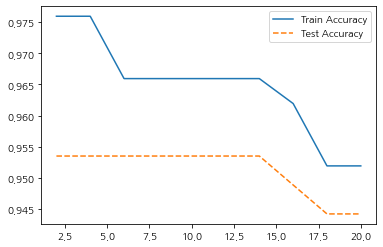

In [47]:
# 모델 정확도 그래프 확인
plt.plot(para_leaf,train_accuracy,linestyle='-',label='Train Accuracy')
plt.plot(para_leaf,test_accuracy,linestyle='--',label='Test Accuracy')
plt.legend()

* 잎사귀 노드의 최소 자료 수 증가에 따라 모델의 정확도는 감소한다. 그러므로 6을 선택한다.

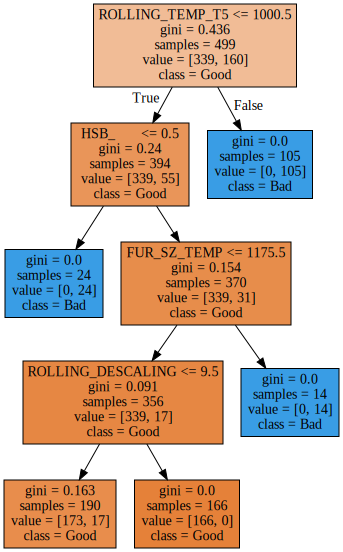

In [48]:
# 잎사귀의 최소 자료 수가 6인 모델
tree_low=DTC(max_depth=4,min_samples_split=20,min_samples_leaf=6,random_state=1234)
tree_low.fit(df_train_x,df_train_y)

export_graphviz(tree_low,out_file='tree_leaf.dot',class_names=['Good','Bad'],\
               feature_names=v_feature_name,impurity=True,filled=True)

with open('tree_leaf.dot') as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))


## 5-3. 최종 모델 선정

In [49]:
tree_final=DTC(max_depth=4,min_samples_split=20,min_samples_leaf=6,random_state=1234)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=6, min_samples_split=20,
                       random_state=1234)

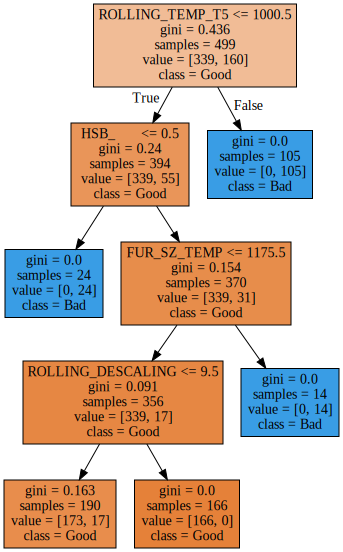

In [50]:
export_graphviz(tree_low,out_file='tree_final.dot',class_names=['Good','Bad'],\
               feature_names=v_feature_name,impurity=True,filled=True)

with open('tree_final.dot') as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

## 5-4. 최종 모델을 이용한 분류 예측

In [51]:
y_pred=tree_final.predict(df_test_x)
print('Accuracy:{0:.3f}\n'.format(tree_final.score(df_test_x,df_test_y)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_test_y,y_pred)))

Accuracy:0.953

Confusion Matrix:
[[144   0]
 [ 10  61]]


* 정분류율은 95.3%로 모델의 정확도가 개선되었다.

# 6. 결론 도출

(1) Scale의 불량 발생의 근본 원인:
    1. ROLLING_TEMP_T5(압연온도)
    2. HSB
    3. FUR_EXTEMP(추출온도)
    4. FUR_SZ_TEMP(가열로 균열대 온도)
    5. ROLLING_DESCALING(압연 중 Descaling 횟수)
    
(2) Scale의 불량 발생 개선 방법:
    1. ROLLING_TEMP_T5(압연온도)를 약 1000.5도 이하로 낮춘다.
    2. HSB를 적용한다.
    3. FUR_EXTEMP(추출온도)를 낮춘다.
    4. FUR_SZ_TEMP(가열로 균열대 온도)를 약 1175.5도 이하로 낮춘다.
    5. ROLLING_DESCALING(압연 중 Descaling 횟수)를 약 9회 이하로 줄인다.